In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import data

In [6]:
df = pd.read_csv("/home/yulius/Latihan-Data-Science/Data/taxi_fare.csv",parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


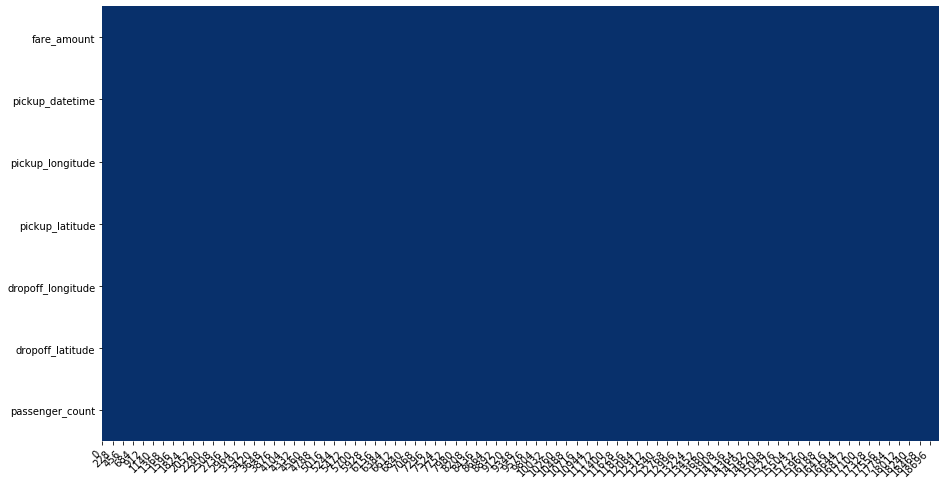

In [10]:
plot_missing_value(df,return_df=True)

## Extract Time Feature

In [12]:
pickup_dt = df.pickup_datetime.dt

In [13]:
df["year"] = pickup_dt.year
df["month"] = pickup_dt.month
df["day"] = pickup_dt.dayofweek
df["hour"] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


## Extract Distance Feature

In [16]:
df["distance"] = np.abs(df.pickup_longitude-df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=["pickup_longitude","dropoff_longitude","pickup_latitude","dropoff_latitude"],inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


## Dataset Split

In [17]:
X = df.drop(columns="fare_amount")
y = df["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15135, 6), (3784, 6), (15135,), (3784,))

## Training

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [21]:
X_train[:1]

,passenger_count,year,month,day,hour,distance
7540,1.0,2009,9,5,10,0.015824


In [28]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["passenger_count","year","distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month","day","hour"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.023073438272658953 0.01690902384161212 0.019014506553895583


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.5s finished


## Feature Importance

jangan dilakuan jika model masih jelek

## Evaluation

### Actual vs prediction plot

In [29]:
from jcopml.plot import plot_actual_vs_prediction,plot_residual

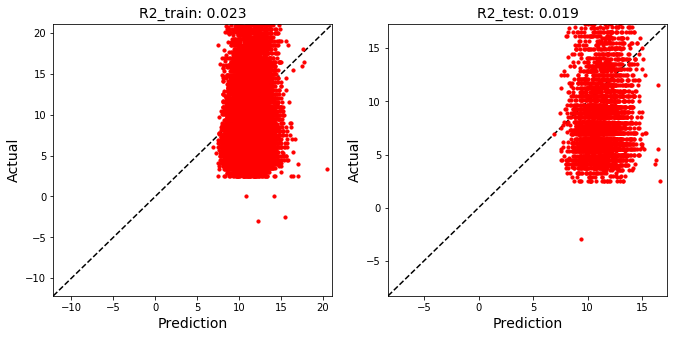

In [32]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

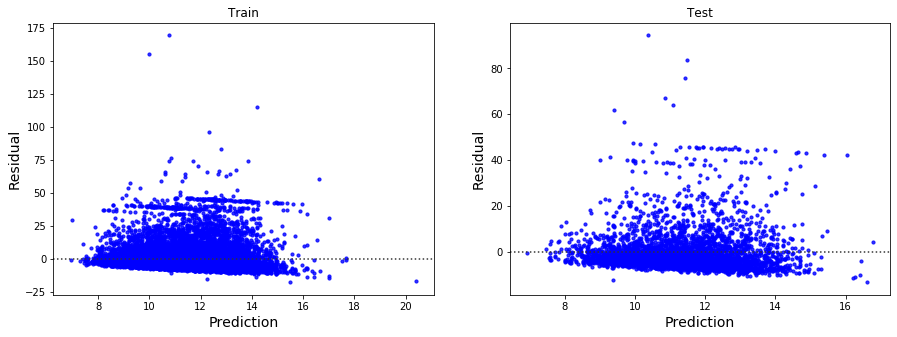

In [31]:
plot_residual(X_train, y_train, X_test, y_test, model)

## Transform

In [33]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2,transform='yeo-johnson'), ["passenger_count","year","distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month","day","hour"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    6.2s finished
/home/yulius/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7225532293342846 0.7196589247970996 0.738119872720659
